In [10]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 939 kB 8.0 MB/s 
     |████████████████████████████████| 251 kB 64.3 MB/s 


In [5]:
!pip install pytorch-ignite
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 259 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 596 kB 53.6 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 51.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [42]:
import json
import torch
import os
import shutil
import tempfile
import time
import glob
import matplotlib.pyplot as plt
import numpy as np
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.apps import download_and_extract
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    CastToTyped,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    ScaleIntensityRanged,
    RandGaussianNoised,
    RandGaussianSmoothd,
    SpatialPadd
)
from monai.utils import set_determinism, first


print_config()

MONAI version: 0.9.dev2224
Numpy version: 1.21.6
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cb6ecb1a22042d4a559b864e74c64d99352dcf7c
MONAI __file__: /usr/local/lib/python3.7/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.19.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [13]:
resource = {
    "Task01_BrainTumour": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task01_BrainTumour.tar",
    "Task02_Heart": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task02_Heart.tar",
    "Task03_Liver": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task03_Liver.tar",
    "Task04_Hippocampus": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task04_Hippocampus.tar",
    "Task05_Prostate": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task05_Prostate.tar",
    "Task06_Lung": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task06_Lung.tar",
    "Task07_Pancreas": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar",
    "Task08_HepaticVessel": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task08_HepaticVessel.tar",
    "Task09_Spleen": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar",
    "Task10_Colon": "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task10_Colon.tar"
}
md5 = {
    "Task01_BrainTumour": "240a19d752f0d9e9101544901065d872",
    "Task02_Heart": "06ee59366e1e5124267b774dbd654057",
    "Task03_Liver": "a90ec6c4aa7f6a3d087205e23d4e6397",
    "Task04_Hippocampus": "9d24dba78a72977dbd1d2e110310f31b",
    "Task05_Prostate": "35138f08b1efaef89d7424d2bcc928db",
    "Task06_Lung": "8afd997733c7fc0432f71255ba4e52dc",
    "Task07_Pancreas": "4f7080cfca169fa8066d17ce6eb061e4",
    "Task08_HepaticVessel": "641d79e80ec66453921d997fbf12a29c",
    "Task09_Spleen": "410d4a301da4e5b2f6f86ec3ddba524e",
    "Task10_Colon": "bad7a188931dc2f6acf72b08eb6202d0"
}
def data(task):  
    
    
    res = resource[task]
    resVal = md5[task]

    taskTar = task + ".tar"
    compressed_file = os.path.join(root_dir, taskTar)
    data_dir = os.path.join(root_dir, task)
    if not os.path.exists(data_dir):
        download_and_extract(res, compressed_file, root_dir, resVal)

    train_images = sorted(
        glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
    train_labels = sorted(
        glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
    data_dicts = [
        {"image": image_name, "label": label_name}
        for image_name, label_name in zip(train_images, train_labels)
    ]
    valSplit = len(data_dicts)//5
    train_files, val_files = data_dicts[:-valSplit], data_dicts[-valSplit:]

    return train_files, val_files

directory = 'task'
root_dir = tempfile.mkdtemp() if directory is None else directory
task = 'Task05_Prostate'
taskNumber = task[4:6]
tf, vf = data(task)

Task05_Prostate.tar: 229MB [00:10, 23.7MB/s]                           

2022-06-14 05:05:05,758 - INFO - Downloaded: task/Task05_Prostate.tar


2022-06-14 05:05:06,236 - INFO - Verified 'Task05_Prostate.tar', md5: 35138f08b1efaef89d7424d2bcc928db.
2022-06-14 05:05:06,238 - INFO - Writing into directory: task.


In [112]:
class ConvertToMultiChannelForClassesd(MapTransform):
   
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [115]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelForClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1450,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.62, 0.62, 1.5),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(keys=["image", "label"], spatial_size=[320, 256, 20]),
        #RandGaussianNoised(keys=["image"], std=0.01, prob=0.15),
        #RandGaussianSmoothd(
        #    keys=["image"],
        #    sigma_x=(0.5, 1.15),
        #    sigma_y=(0.5, 1.15),
        #    sigma_z=(0.5, 1.15),
        #    prob=0.15,
        #),
        #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        #RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        #NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        #RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        #RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1450,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        Spacingd(
            keys=["image", "label"],
            pixdim=(0.62, 0.62, 1.5),
            mode=("bilinear", "nearest"),
        ),
        #NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        EnsureTyped(keys=["image", "label"]),
        CastToTyped(keys=["image", "label"], dtype=(np.float32, np.uint8)),
    ]
)

label shape: torch.Size([2, 323, 323, 47])


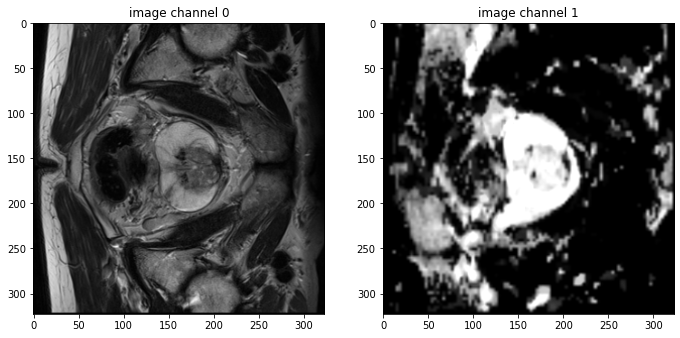

label shape: torch.Size([2, 323, 323, 47])


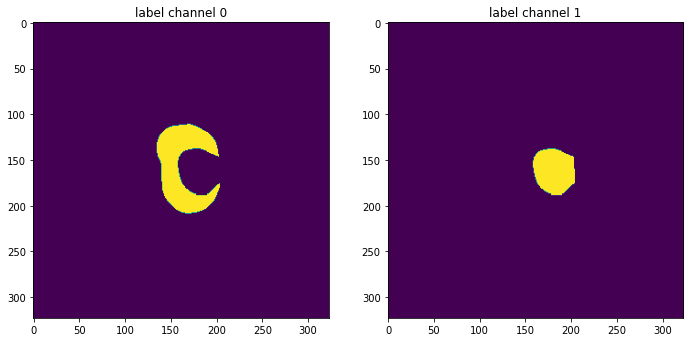

In [157]:
temp_ds = Dataset(data=vf, transform=train_transform)
temp = temp_ds[2]
pltimg = temp["image"].shape
pltlab = temp["label"].shape

print(f"label shape: {pltimg}")
plt.figure("image", (24, 6))
for i in range(pltimg[0]):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(temp["image"][i, :, :, 21].detach().cpu(), cmap="gray")
plt.show()

print(f"label shape: {pltlab}")
plt.figure("label", (18, 6))
for i in range(pltlab[0]):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(temp["label"][i, :, :, 21].detach().cpu())
plt.show()